In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
import keras
from tensorflow.keras import backend as K
from scipy.linalg import eigh


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [34]:
# Load Data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Split data
y_train = train['label']
X_train = train.drop(['label'], axis=1)
X_test = test
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

### Data Normalization

In [36]:
X_train = X_train/255
X_test = X_test/255

IMAGE LABEL: 0


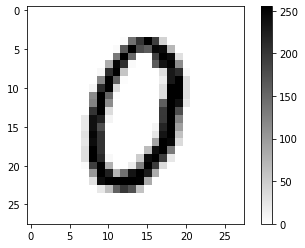

In [5]:
# Visualize single digit
digit_array = train.loc[5, "pixel0":]
arr = np.array(digit_array) 

#.reshape(a, (28,28))
image_array = np.reshape(arr, (28,28))

digit_img = plt.imshow(image_array, cmap=plt.cm.binary)
plt.colorbar(digit_img)
print("IMAGE LABEL: {}".format(train.loc[5, "label"]))

## PCA Implementation

In [6]:
standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(X_train)
standardized_data.shape

(42000, 784)

In [7]:
# Calculate covariance matrix
cov_matrix = np.matmul(standardized_data.T, standardized_data)
cov_matrix.shape

(784, 784)

In [8]:
# Calculate eigenvalues and eigenvectors
lambdas, vectors = eigh(cov_matrix, eigvals=(782, 783))
vectors.shape

(784, 2)

In [9]:
vectors = vectors.T
vectors.shape

(2, 784)

In [10]:
#Calculate unit vectors U1=V1 and new coordinates
new_coordinates = np.matmul(vectors, standardized_data.T)
print(new_coordinates.shape)
new_coordinates = np.vstack((new_coordinates, y_train)).T

(2, 42000)


In [11]:
df_new = pd.DataFrame(new_coordinates, columns=["f1", "f2", "labels"])
df_new.head()

,f1,f2,labels
0,-5.226445,-5.140478,1.0
1,6.032996,19.292332,0.0
2,-1.705813,-7.644503,1.0
3,5.836139,-0.474207,4.0
4,6.024818,26.559574,0.0


In [13]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.n_components = 784
pca_data = pca.fit_transform(standardized_data)
percent_variance_retained = pca.explained_variance_ / np.sum(pca.explained_variance_)

cum_variance_retained = np.cumsum(percent_variance_retained)

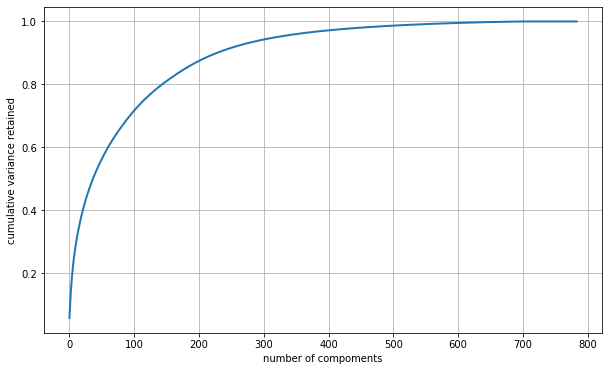

In [14]:
plt.figure(1, figsize=(10, 6))
plt.clf()
plt.plot(cum_variance_retained, linewidth=2)
plt.axis("tight")
plt.grid()
plt.xlabel("number of compoments")
plt.ylabel("cumulative variance retained")
plt.savefig("pca_cumulative_variance.png")
plt.show()

## CNN Model

### Preprocessing Data

In [37]:
X_train = np.array(X_train)
y_train = np.array(y_train)

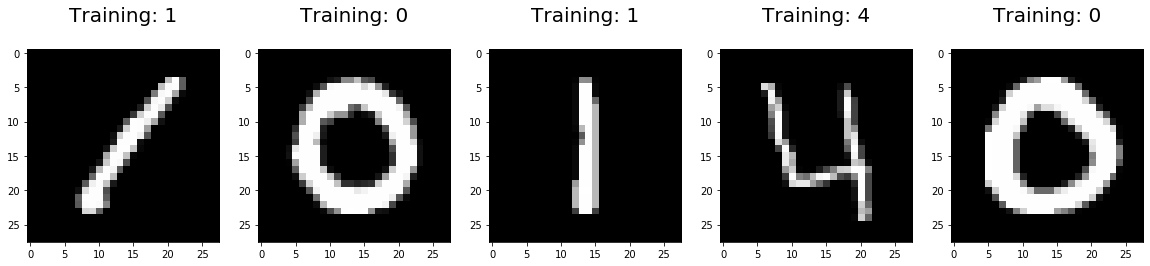

In [38]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(X_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [32]:
# Reshaping the input shapes to get it in the shape which the model expects to recieve later.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
print(X_train.shape, y_train.shape)

(42000, 28, 28, 1) (42000, 10)


In [17]:
# Encoding the labels and making them as the class value and finally converting them as categorical values.
nclasses = y_train.max() - y_train.min() + 1
y_train = to_categorical(y_train, num_classes = nclasses)
print("Shape of ytrain after encoding: ", y_train.shape)

Shape of ytrain after encoding:  (42000, 10)


### Building CNN Model

In [18]:
# Building a CNN model
input_shape = (28,28,1)
X_input = Input(input_shape)

# layer 1
x = Conv2D(64,(3,3),strides=(1,1),name='layer_conv1',padding='same')(X_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool1')(x)
# layer 2
x = Conv2D(32,(3,3),strides=(1,1),name='layer_conv2',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool2')(x)
# layer 3
x = Conv2D(32,(3,3),strides=(1,1),name='conv3',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2), name='maxPool3')(x)
# fc
x = Flatten()(x)
x = Dense(64,activation ='relu',name='fc0')(x)
x = Dropout(0.25)(x)
x = Dense(32,activation ='relu',name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(10,activation ='softmax',name='fc2')(x)

conv_model = Model(inputs=X_input, outputs=x, name='Predict')
conv_model.summary()

Model: "Predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
maxPool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128 

In [19]:
def compile_model(conv_model, optimizer='adam', loss='categorical_crossentropy'):
    conv_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
    
def train_model(conv_model, train, test, epochs, split):
    history = conv_model.fit(train, test, shuffle=True, epochs=epochs, batch_size=100,validation_split=split)
    return history

In [20]:
# Training the model using the above function built to build, compile and train the model
compile_model(conv_model, 'adam', 'categorical_crossentropy')

# train the model for as many epochs as you want but I found training it above 80 will not help us and eventually increase overfitting.
model_history = train_model(conv_model, X_train, y_train, 40, 0.2)

Epoch 1/40
336/336 [==============================] - 49s 145ms/step - loss: 0.6567 - accuracy: 0.7910 - val_loss: 1.4219 - val_accuracy: 0.4815
Epoch 2/40
336/336 [==============================] - 46s 137ms/step - loss: 0.1562 - accuracy: 0.9572 - val_loss: 0.0770 - val_accuracy: 0.9779
Epoch 3/40
336/336 [==============================] - 41s 122ms/step - loss: 0.1028 - accuracy: 0.9717 - val_loss: 0.0615 - val_accuracy: 0.9815
Epoch 4/40
336/336 [==============================] - 41s 121ms/step - loss: 0.0821 - accuracy: 0.9772 - val_loss: 0.0631 - val_accuracy: 0.9824
Epoch 5/40
336/336 [==============================] - 40s 119ms/step - loss: 0.0687 - accuracy: 0.9808 - val_loss: 0.0522 - val_accuracy: 0.9844
Epoch 6/40
336/336 [==============================] - 39s 115ms/step - loss: 0.0571 - accuracy: 0.9836 - val_loss: 0.0421 - val_accuracy: 0.9876
Epoch 7/40
336/336 [==============================] - 38s 113ms/step - loss: 0.0549 - accuracy: 0.9845 - val_loss: 0.0656 - val_ac

### Model Evaluation

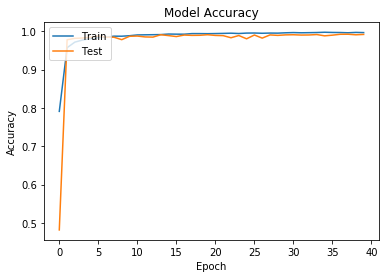

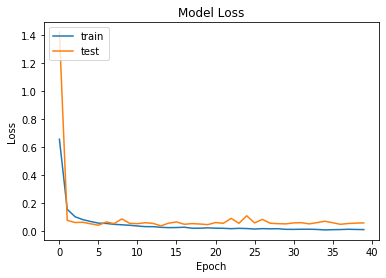

In [29]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Model_loss.png')
plt.show()

In [25]:
print("Loss of the model is - " , conv_model.evaluate(X_train,y_train)[0])
print("Accuracy of the model is - " , conv_model.evaluate(X_train,y_train)[1]*100 , "%")

1313/1313 [==============================] - 15s 12ms/step - loss: 0.0131 - accuracy: 0.9980
Loss of the model is -  0.013137700967490673
1313/1313 [==============================] - 13s 10ms/step - loss: 0.0131 - accuracy: 0.9980
Accuracy of the model is -  99.80000257492065 %
